### Albania, Canada, China PR, France 네 가지 나라로 분류

In [1]:
import cv2
import numpy as np
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import os
import pandas as pd

In [2]:
def read_data(fin):
    """ 이미지 파일을 읽어 들여 이미지 데이터, 국가를 리턴"""
    data = pd.read_csv(fin)
    target_li=[]
    data_li=[]
    for i in range(len(data)):
        image_id = int(data.iloc[i][0])
        target_nation = data.iloc[i][3]
        working_dir = fin.split('/')[:-1]
        image_path = '/'.join(working_dir)+'/valid_pictures/'+ target_nation +'/{}.png'.format(image_id)
       
        if (os.path.isfile(image_path)):
            image_data = cv2.imread(image_path, 0)
            data_li.append(image_data)
            target_li.append(target_nation)

    return (np.array(data_li), np.array(target_li))

In [3]:
def create_train_test_data(image_data, label_li):
    #데이터 수, 세로 픽셀, 가로 픽셀 
    n_samples, image_h, image_w = image_data.shape

    X = image_data.reshape(n_samples, -1)
 
    n_features = X.shape[1]
    y = label_li
    #클래스 갯수는 지금 테스트로 돌려볼 때만 4로!!!!
    n_classes = 4
    
    print("total dataset size:")
    print("n_samples: %d" % n_samples)
    print("n_features: %d" % n_features)
    print("n_classes: %d" % n_classes)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    return(X_train, X_test, y_train, y_test)

In [4]:
def extract_features(X_train, X_test, n_components):
    print("Extracting the top %d eigenfaces from %d faces"
         % (n_components, X_train.shape[0]))
    pca = PCA(n_components = n_components,
             svd_solver='randomized', whiten=True).fit(X_train)
    
    eigenfaces = pca.components_.reshape((n_components, 48, 48))
    #주성분 차원바꾸기
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test) 
    
    return(X_train_pca, X_test_pca, eigenfaces)

In [5]:
def train_test_classifier(X_train_pca, X_test_pca, y_train, y_test):
    print("Fitting the classifier to the training set")
    param_grid={'C':[1e3, 5e3, 1e4, 5e4, 1e5],
               'gamma':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],}
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(X_train_pca, y_train)
    print("best estimator found by grid search")
    print(clf.best_estimator_)
    print("predicting people's names on the test set")
    y_pred = clf.predict(X_test_pca)
    print(classification_report(y_test, y_pred))

In [6]:
from matplotlib import pyplot as plt

def plot_gallery(images, n_col=5):
    n_row = round(images.shape[0]/n_col)
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0.1, left=0.01, right=0.99, top=0.90, hspace=0.35)
    
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i+1)
        #플롯값의 최대치를 흰색으로, 최소치를 검은색으로 변환 ( 특징이 되는 곳이 흰색으로 두드러지게 하는것)
        plt.imshow(images[i], cmap='gray')
        plt.xticks(())
        plt.yticks(())

total dataset size:
n_samples: 4805
n_features: 2304
n_classes: 4
Extracting the top 10 eigenfaces from 3603 faces
Fitting the classifier to the training set


C:\Users\HanSung\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best estimator found by grid search
SVC(C=10000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
predicting people's names on the test set
              precision    recall  f1-score   support

   Argentina       0.31      0.51      0.39       152
     England       0.64      0.40      0.50       385
      France       0.44      0.45      0.44       191
     Germany       0.61      0.62      0.62       276
       Spain       0.43      0.51      0.46       198

    accuracy                           0.49      1202
   macro avg       0.49      0.50      0.48      1202
weighted avg       0.53      0.49      0.50      1202



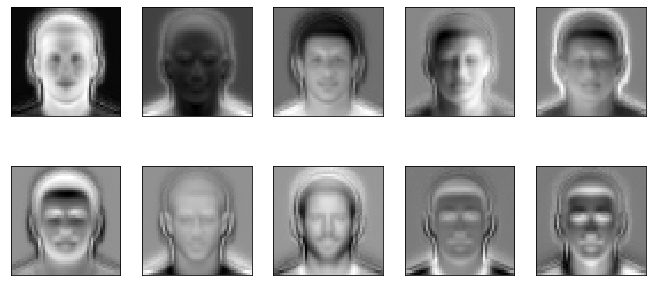

In [7]:
argv = sys.argv
image_data, label = read_data('D:/DL/WAYF/Data/4country.csv')
n_eigenface = 10
X_train, X_test, y_train, y_test = create_train_test_data(image_data, label)
X_train_pca, X_test_pca, eigenface = extract_features(X_train, X_test, n_eigenface)
train_test_classifier(X_train_pca, X_test_pca, y_train, y_test)
plot_gallery(eigenface)
plt.show()